# ScratchNet
Ein einfaches künstliches neuronales Netz mit einer von `keras` inspirierten API.
Hinweis: Das Netz wurde ausschließlich für Lernzwecke verfasst.

In [0]:
%tensorflow_version 2.x
!pip install --upgrade deeplearning2020

TensorFlow 2.x selected.
     |████████████████████████████████| 399kB 3.2MB/s 
  Created wheel for deeplearning2020: filename=deeplearning2020-0.4.8-py2.py3-none-any.whl size=6424 sha256=4ff5ea2f814b932191a4c9924ae1c6d25120cc0749e6562bccdfd43f1ae6031b
  Stored in directory: /root/.cache/pip/wheels/e3/b0/4a/8a76f8d4841cbb93d270edd2a88685d7209aef0a08d0af2fc6
  Created wheel for kerasltisubmission: filename=kerasltisubmission-0.4.5-py2.py3-none-any.whl size=7532 sha256=df789a751b92d87753381edd42b72c437fb92a5f6f116880da04d217c67397dc
  Stored in directory: /root/.cache/pip/wheels/17/0e/e3/6022cb4bec452a01b8629e91249cdb917c7c509270bf314a0b
Successfully built deeplearning2020 kerasltisubmission


In [0]:
import abc
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import time
from tqdm import tqdm, trange
from deeplearning2020 import helpers

In [0]:
class DifferentiableFunction(abc.ABC):
    """ Abstrakte Klasse einer differenzierbaren Funktion
        Die Implementierung der Methoden erfolgt durch Spezialisierung.
    """

    def derivative(self, net_input):
        pass

    def __call__(self, net_input):
        pass

In [0]:
class Sigmoid(DifferentiableFunction):
    """ Sigmoid Aktivierungsfunktion
        Stetige und differenzierbare Funktion, dessen Graph der Treppenfunktion ähnelt.
    """

    def derivative(self, net_input):
        return self(net_input) * (1 - self(net_input))

    def __call__(self, net_input):
        return 1 / (1 + np.exp(-net_input))

In [0]:
class SquaredError(DifferentiableFunction):
    """ Quadratische Fehlerfunktion
        Durch das Quadrieren wird sichergestellt, dass der Fehler nicht negativ wird
        und höhere Differenzen stärker ins Gewicht fallen.
    """

    def derivative(self, target, actual):
        return actual - target

    def __call__(self, target, actual):
        return 0.5 * np.sum((target - actual) ** 2)

In [0]:
class DenseLayer:
    """ DenseLayer

        Implementiert einen Layer, dessen Neuronen mit jeweils allen Neuronen aus der Schicht davor verbunden sind. 
    """

    def __init__(
        self,
        neuron_count,
        depth=None,
        activation=None,
        biases=None,
        weights=None,
        prev_layer=None,
        next_layer=None,
    ):
        """ Initialisiert DenseLayer L """
        self.depth = depth
        self.next_layer = next_layer
        self.prev_layer = prev_layer

        self.neuron_count = neuron_count
        self.activation_func = activation or Sigmoid()

        self.weights = weights
        self.biases = biases

    def prepare_inputs(self, images, labels=None):
        """ Bereitet die Eingabedaten für den DenseLayer L vor

            Ein `DenseLayer` benötigt keine besondere Vorbereitung der Eingabe, anders als zum Beispiel der `FlattenLayer`.
        """
        return images if labels is None else images, labels

    def initialize_parameters(self):
        """ Initialisiert die Netzparameter für DenseLayer L

            Die Parameter der Layer werden zufällig gewählt.
            Die Gewichte von L werden durch eine Matrix mit `shape=(n_L, n_P)` repräsentiert,
            wobei `n_L` die Anzahl an Neuronen des aktuellen Layer `L` und `n_P` die Anzahl an Neuronen im vorigen Layer `P = L - 1` ist.
            Der Eintrag `(i,j)` enspricht dem Gewicht, mit dem die Neuronen `i` (Layer `L`) und `j` (Layer `P = L - 1`) miteinander verbunden sind.

            Die Biases von L werden durch eine Matrix mit `shape=(n_L, 1)` repräsentiert,
            wobei `n_L` die Anzahl an Neuronen des aktuellen Layer `L` ist.
            Der Eintrag `(i,1)` enspricht dem Bias, der zu dem Neuron `i` im aktuellen Layer `L` addiert / subtrahiert wird.
            Da die Subtraktion des Biases `b_i = biases[i,1]` der Addition des negierten Bias `-b_i` entspricht, spielt dies für das Netz keine Rolle.
        """
        # `np.random.randn(d0, d1, ..., dn)` initialisiert eine Matrix mit shape (d0, d1, ..., dn) mit Werten aus der Standard Normalverteilung
        if self.weights is None:
            self.weights = np.random.randn(
                self.neuron_count, self.prev_layer.neuron_count
            )
        if self.biases is None:
            self.biases = np.random.randn(self.neuron_count, 1)

    def compute_cost_gradients(self, label_vec, cost_func):
        """ Bestimmt die Gradienten ∇aLC der Kostenfunktion C in Abhängigkeit der 
            Aktivierungen in DenseLayer L

            Dieser lässt sich sehr einfach ohne Abhängigkeiten berechnen:
            Dazu wird der Gradientenvektor der Kostenfunktion für ein Trainingssample mit dem
            Gradientenvektor der Aktivierungen `self.activation_vec` in Layer `L` multipliziert,
            da die Aktivierungen als Eingabe der Kostenfunktion diese direkt beeinflussen.
            Diese Gradienten bilden dann die Startwerte für den Backpropagation Schritt;
            `compute_cost_gradients` wird demnach nur auf dem Output Layer aufgerufen.
            Anschließend werden die Gradienten der Weights und Biases des Layers in 
            `_update_layer_gradients` aktualisiert.
        """
        cost_gradients = cost_func.derivative(
            self.activation_vec, label_vec
        ) * self.activation_func.derivative(self.layer_inputs)
        self._update_layer_gradients(cost_gradients)
        return cost_gradients

    def feed_backwards(self, prev_input_gradients):
        """ Feed-backward Schritt für DenseLayer L zur Berechnung des neuen Eingabegradienten δL

            Im Backpropagation Schritt wird der Fehler des Netzes rückwärts durch das Netz
            propagiert. Da die Werte rückwärts propagiert werden, ist der vorherige Layer 
            `self.next_layer` (L+1). Es wird das Produkt aus der transponierten Gewichtsmatrix 
            (WL)T des vorherigen Layer mit den Gradienten δL+1 aus dem letzen `feed_backwards` Schritt
            gebildet und mit dem Gradientenvektor der Aktivierungen in Layer L multipliziert.
            Die Gewichtsmatrix hat eine `shape=(n_L+1, n_L)`, und wird transponiert, da wir nun rückwärts
            durch das Netz propagieren und mit den Gradienten aus dem vorigen Layer L+1
            mit `shape=(n_L+1, 1)` multiplizieren wollen. Durch das Transponieren erhalten wir 
            eine `shape=(n_L, n_L+1)` so, dass das Ergebnis mit dem Gradientenvektor der Aktivierungen
            in Layer L mit `shape=(n_L+1, 1)` multiplizieren können.

            Als Errinnerung: `self.layer_inputs` ist der Vektor, dessen Einträge jeweils den 
            summierten Eingaben der Neuronen in Layer L entsprechen.
            Anschließend werden die Gradienten der Weights und Biases des Layers in `_update_layer_gradients`
            aktualsiert.
        """
        new_input_gradients = np.dot(
            self.next_layer.weights.transpose(), prev_input_gradients
        ) * self.activation_func.derivative(self.layer_inputs)
        self._update_layer_gradients(new_input_gradients)
        return new_input_gradients

    def _update_layer_gradients(self, input_gradients):
        """ Aktualisiert die Gradienten der Weights und Biases für DenseLayer L

            Die Gradienten der Biases entsprechen den `input_gradients` in diesem Layer,
            da die biases direkt proportionalen Einfluss auf Aktivierungen der Neuronen in Layer L haben.

            Die Gradienten der Gewichte an den Kanten zu dem vorigen Layer entsprechen dem Produkt
            der `input_gradients` mit dem transponierten Gradientenvektor der Aktivierungen des 
            vorigen Layers L-1. Ebenso wie in `feed_backwards` ist hier die Reihenfolge der Multiplikation vertauscht
            und die Transposition wird benötigt, damit die Matrizen die richtige Form haben.
        """
        self.bias_gradients = input_gradients
        self.weight_gradients = np.dot(
            input_gradients, self.prev_layer.activation_vec.transpose()
        )

    def feed_forward_layer(self, input_activations):
        """ Feedforward Schritt für DenseLayer L

            Als Eingabe werden die Aktivierungen aus dem vorherigen Layer übergeben.
            Zunächst werden die summierten Eingaben der jeweiligen Neuronen in Layer L berechnet.
            Da es sich um einen `DenseLayer` handelt wird die Gewichtsmatrix der Kanten zwischen den 
            Layern P und L (`shape=(n_L, n_P)`) mit den `input_activations` (`shape=(n_P, 1)` mit P=L-1)
            aller Neuronen aus dem vorherigen Layer multipliziert.
            Auf die summierten Eingaben der Neuronen (`shape=(n_L, 1)`) werden dann die 
            Biases des Layer L (`shape=(n_L, 1)`) addiert und as Ergebnis in `self.layer_inputs` zwischengespeichert.
            Abschließend werden auch die Aktivierungen der Neuronen in Layer L berechnet, indem die Aktivierungsfunktion
            auf die summierten Eingaben der Neuronen angewandt wird.
        """
        self.layer_inputs = np.dot(
            self.weights, input_activations) + self.biases
        self.activation_vec = self.activation_func(self.layer_inputs)
        return self.activation_vec

    def inspect(self):
        """ Inspiziert DenseLayer L """
        print(f"--------- Layer L={self.depth} ---------")
        print(f"  # Neuronen: {self.neuron_count}")
        for n in range(self.neuron_count):
            print(f"    Neuron {n}")
            if self.prev_layer:
                for w in self.weights[n]:
                    print(f"      Weight: {w}")
                print(f"      Bias: {self.biases[n][0]}")

In [0]:
class FlattenLayer(DenseLayer):
    def __init__(self, input_shape):
        """ Initialisiert den FlattenLayer

            Die Unterscheidung zu einem `DenseLayer` ist in unserer Implementierung fast nur semantisch.
            Lediglich die Anzahl der Neuronen wird durch die `input_shape` vorgegeben und die Eingaben des
            Layers werden vorher mit `reshape` auf den Input Layer angepasst.  
        """
        total_input_neurons = 1
        # Beispiele:
        # (28,28)   wird zu 28*28=784
        # (28,28,1) wird zu 28*28*1=784
        # (4,4,2)   wird zu 4*4*2=32
        for dim in input_shape:
            total_input_neurons *= dim
        super().__init__(neuron_count=total_input_neurons)

    def initialize_parameters(self):
        """ Initialisiert die Netzparameter für FlattenLayer L

            Für einen `FlattenLayer` ist keine Initialisierung erforderlich, da dieser nur als
            Input Layer verwendet wird und die Aktivierungen des `FlattenLayer` durch die Werte
            des aktuellen Trainingsbeispiels (siehe `feed_forward_layer`) gegeben sind.
        """
        pass

    def feed_forward_layer(self, input_activations):
        """ Führt den Feedforward Schritt für FlattenLayer L durch

            Für einen `FlattenLayer`, der als Input Layer dient, sind `input_activations` die Werte
            des aktuellen Trainingsbeispiels, welche unverändert als Aktivierungen der Neuronen übernommen werden.
        """
        self.activation_vec = input_activations
        return input_activations

    def prepare_inputs(self, images, labels=None):
        """ Bereitet die Eingabedaten für FlattenLayer L vor

            Der `FlattenLayer` nutzt diese Methode um die Eingabematrizen mit `reshape` in eine flache Form zu bringen.
            Die Shape der Einträge dieser flachen Matrix ist durch `self.neuron_count` vorgegeben.
            Zudem werden die Eingabematrizen wie Labels (falls vorhanden) um eine Dimension erweitert,
            um auf jeden Fall transponiert werden zu können.
        """
        flattened_images = images.reshape(
            images.shape[0], self.neuron_count, 1)
        if labels is not None:
            labels = labels.reshape(labels.shape[0], -1, 1)
            return flattened_images, labels
        return flattened_images

In [0]:
class ScratchNet:
    def __init__(self, layers):
        """ Initialisert das Netz

            Die Layer des Netzes werden miteinander verkettet,
            sodass jeder Layer L seinen Index und eine Referenz auf seine Nachbarn erhält.
            Anschließend können die Parameter der Layer initialisiert werden.
        """
        self.learning_rate = 0.5
        self.cost_func = SquaredError()
        self.layers = layers
        for index, layer in enumerate(self.layers):
            layer.prev_layer = self.layers[index - 1] if index > 0 else None
            layer.next_layer = (
                self.layers[index + 1] if index +
                1 < len(self.layers) else None
            )
            layer.depth = index
            layer.initialize_parameters()

    def _calculate_loss(self, input_samples):
        """ Berechnet den Fehler des Netzes auf den übergebenen `input_samples`

            Der Fehler ist dabei definiert als der Durchschnitt über den Fehlern der 
            `input_samples`. Um den Fehler eines Samples zu berechnen, wird dessen Ausgabe
            im Feedforward Schritt berechnet und mit dem erwarteten Label als Argument der
            Kostenfunktion `cost_func` übergeben.
        """
        total_error = 0.0
        for sample in input_samples:
            image, label_vec = sample
            output_activations = self._feed_forward(image)
            total_error += self.cost_func(label_vec, output_activations)
        return total_error / len(input_samples)

    def _calculate_accuracy(self, input_samples):
        """ Berechnet die Accuracy des Netzes auf den übergebenen `input_samples`

            Für jedes Sample wird im Feedforward Schritt die Ausgabe des Netzes berechnet und
            mithilfe der `np.argmax` Funktion, welche für eine Matrix den Index des Eintrags
            mit dem höchsten Wert berechnet, mit dem erwarteten Label verglichen.
            Dabei haben sowohl die Aktivierungsmatrix im Output Layer als auch die Matrix des 
            erwarteten Label eine `shape=(nL,1)` wobei `nL` die Zahl der Neuronen im Output Layer L sind.
            Die Accuracy ist dann definiert als der Quotient `num_correct/len(input_samples)`.
        """
        results = [
            (np.argmax(self._feed_forward(image)), np.argmax(expected_label))
            for image, expected_label in input_samples
        ]
        num_correct = sum(int(x == y) for (x, y) in results)
        return num_correct / len(input_samples)

    def _feed_forward(self, input_sample):
        """ Feedforward eines Samples durch das Netz """
        for layer in self.layers:
            # `input_sample` wird mit jedem Layer überschrieben
            # Jeder Layer speichert dabei die Aktivierungen seiner Neuronen in `self.activation_vec`
            input_sample = layer.feed_forward_layer(input_sample)
        return input_sample

    def _update_parameters(self, input_samples):
        """ Aktualisiert die Parameter (Weights und Biases) des Netzes

            Für jedes Input Sample werden mit Backpropagation die Gradienten für die 
            Gewichte (`sample_weight_updates`) und Biases (`sample_bias_updates`) berechnet.
            Die Summen aller Gewichtsupdates (`weight_updates`) und Bias Updates (`bias_updates`)
            werden anschliessend gemittelt und mit der Learning Rate multipliziert, bevor sie auf
            die Parameter angewandt werden.
        """
        # Der Inputlayer wird ignoriert, da er die Eingaben aus dem Trainingsset nicht verändert
        weight_gradients = [np.zeros(layer.weights.shape)
                            for layer in self.layers[1:]]
        bias_gradients = [np.zeros(layer.biases.shape)
                          for layer in self.layers[1:]]

        # Summe aller Gewichts- und Bias Updates
        for sample in input_samples:
            sample_weight_gradients, sample_bias_gradients = self._backpropagate(
                sample)
            # Addiert zu den Gradienten
            weight_gradients = np.add(
                weight_gradients, sample_weight_gradients)
            bias_gradients = np.add(bias_gradients, sample_bias_gradients)

        # Durchschnitt über alle Gewichts- und Bias Updates
        # Der Einfluss der Updates wird durch die `learning_rate` beeinflusst
        for layer, layer_weight_gradients, layer_bias_gradients in zip(
            self.layers[1:], weight_gradients, bias_gradients
        ):
            layer.weights += (
                self.learning_rate *
                layer_weight_gradients / len(input_samples)
            )
            layer.biases += (
                self.learning_rate * layer_bias_gradients / len(input_samples)
            )

    def _backpropagate(self, training_sample):
        """ Berechnet effizient die Gradienten der Netzparameter

            Der Schritt wird für ein `training_sample` durchgeführt.
            Dem Backpropagation Schritt geht zunächst der Feedforward Schritt voraus.
            Anschließend wird der Gradientenvektor der Kostenfunktion in Abhängigkeit der Aktivierungen im
            Output Layer mit `compute_cost_gradients` berechnet und durch die Hidden Layer rückwärts propagiert.
            Die Rückgabe ist eine Liste mit den Gradienten der Gewichte und Biases für jeden Layer.
        """
        train_input, train_output = training_sample
        self._feed_forward(train_input)
        # Berechnet die Gradienten des letzen Layer in Abhängigkeit der Kostenfunktion
        gradients = self.layers[-1].compute_cost_gradients(
            train_output, cost_func=self.cost_func
        )

        # Nur für die Hidden Layer werden die Gradienten rückwärts durch das Netz propagiert
        for layer in reversed(self.layers[1:-1]):
            # `gradients` wird mit jedem Layer überschrieben
            gradients = layer.feed_backwards(gradients)

        # Akkumuliert alle Gradienten, die mit Backpropagation berechnet wurden
        weight_gradients = [
            layer.weight_gradients for layer in self.layers[1:]]
        bias_gradients = [layer.bias_gradients for layer in self.layers[1:]]
        return weight_gradients, bias_gradients

    def _stochastic_gradient_descent(
        self, training_data, epochs=1, batch_size=1, avg_lookbehind=None
    ):
        """ Trainiert das Netz durch iteratives Anpassen der Parameter nach dem
            Stochastic Gradient Descent Verfahren

            Mit jeder Epoche wird das gesamte Trainingsset einmal durchlaufen.
            Nach jeder Epoche wird das Trainingsset durchgemischt und die Parameter (Gewichte und Biases)
            *für jeden Batch* aktualisiert sowie der `loss` und die `accuracy` berechnet.
            Die Fehler und Accuracies während des Trainingsprozesses werden in `losses` und `accuracies`
            akkumuliert und zurückgegeben, falls man diese grafisch darstellen möchte.
        """
        losses, accuracies = list(), list()
        training_set_size = len(training_data)

        # Wir bilden den running average aus loss und accuracy
        # Falls nicht anders spezifiziert, wird dieser aus den letzen 10% der batches gebildet
        avg_lookbehind = avg_lookbehind or int(
            0.10 * training_set_size / batch_size)
        running_loss, running_acc = [], []

        for epoch in range(epochs):
            # Mischt `training_data`
            # Dadurch sind die Batches mit jedem Epoch anders zusammengestellt
            random.shuffle(training_data)

            with tqdm(total=training_set_size) as progress:
                for t in range(0, training_set_size, batch_size):
                    batch = training_data[t: t + batch_size]

                    # Aktualisiert die Parameter des Netzes
                    self._update_parameters(batch)
                    loss, accuracy = (
                        self._calculate_loss(batch),
                        self._calculate_accuracy(batch),
                    )

                    # Bildet den running average für loss und accuracy aus den letzten `avg_lookbehind` Werten
                    running_loss = ([loss] + running_loss)[:avg_lookbehind]
                    running_acc = ([accuracy] + running_acc)[:avg_lookbehind]
                    running_loss_avg = np.average(running_loss)
                    running_acc_avg = np.average(running_acc)
                    losses.append(running_loss_avg)
                    accuracies.append(running_acc_avg)

                    # Aktualsiert die progressbar
                    progress.set_description(f"Epoch {epoch+1}")
                    progress.set_postfix(
                        loss="{0:.3f}".format(running_loss_avg),
                        accuracy="{0:.2f}".format(running_acc_avg),
                    )

                    progress.update(len(batch))
        return losses, accuracies

    def fit(self, train_images, train_labels, epochs=1, batch_size=1):
        """ Startet den Trainingsprozess

            Das Netz wird mit Stochastic Gradient Descent trainiert,
            wodurch die Trainingszeit erheblich verringert wird.
        """
        # Preprocessing der Trainingsdaten durch den Input Layer
        train_images, train_labels = self.layers[0].prepare_inputs(
            train_images, train_labels
        )
        training_data = list(zip(train_images, train_labels))
        losses, accuracies = self._stochastic_gradient_descent(
            training_data, epochs=epochs, batch_size=batch_size
        )
        return losses, accuracies

    def predict(self, model_inputs):
        """ Prognostiziert eine Ausgabe für beliebig viele Eingaben

            Die "Vorhersage" des Netzes entspricht den Aktivierungen im Output Layer
            `self.layers[-1]` nach dem Feedforward Schritt.
        """
        # Preprocessing der `model_inputs` durch den Input Layer
        model_inputs = self.layers[0].prepare_inputs(model_inputs)
        predicted = np.zeros(
            (model_inputs.shape[0], self.layers[-1].neuron_count, 1))
        for i, model_input in enumerate(model_inputs):
            predicted[i] = self._feed_forward(model_input)
        return predicted

    def evaluate(self, validation_images, validation_labels):
        """ Evaluiert das Netz auf Validierungsdaten

            In diesem Schritt werden `loss` und `accuracy` der Validierungsdaten berechnet,
            da diese für die Bewertung des Netzes am aussagekräftigsten sind. 
        """
        # Preprocessing der Validierungsdaten durch den Input Layer
        validation_images, validation_labels = self.layers[0].prepare_inputs(
            validation_images, validation_labels
        )
        validation_data = list(zip(validation_images, validation_labels))
        return (
            self._calculate_loss(validation_data),
            self._calculate_accuracy(validation_data),
        )

    def compile(self, learning_rate=None, loss=None):
        """ Kompiliert das Netz

            Dieses Netz implementiert nur Stochastic Gradient Descent, weshalb anders als
            bei `keras` kein Optimizer übergeben wird.
            Diese Funktion dient nur der Konfiguration von Parametern,
            die während des Trainings nicht mehr verändert werden.
        """
        self.learning_rate = learning_rate or self.learning_rate
        self.cost_func = loss or self.cost_func

    def inspect(self):
        """ Inspiziert das Netz """
        print(f"--------- {self.__class__.__name__} ---------")
        print(f"  # Inputs: {self.layers[0].neuron_count}")
        for layer in self.layers:
            layer.inspect()

In [0]:
def plot_loss_and_accuracy(losses, accuracies, xlabel):
    """ Plottet den Verlauf der `loss` und `accuracy` Werte """
    plt.plot(losses, label="loss")
    plt.plot(accuracies, label="accuracy")
    plt.legend(loc="upper left")
    plt.xlabel(xlabel)
    plt.ylim(top=1, bottom=0)
    plt.show()

## Beispielnetz für das XOR Problem

Epoch 1: 100%|██████████| 40000/40000 [00:36<00:00, 1082.07it/s, accuracy=1.00, loss=0.013]


Trainingsdauer: 37.1s
Validation loss: 0.011670468778195359
Validation accuracy: 1.0


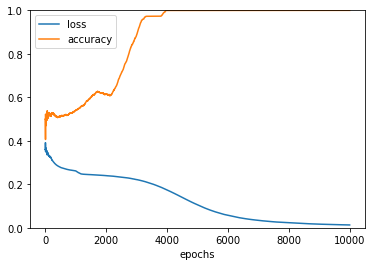

In [0]:
xor_train_inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
xor_train_labels = np.array([[0], [1], [1], [0]])

xor_total_classes = 2
xor_train_vec_labels = tf.keras.utils.to_categorical(xor_train_labels, xor_total_classes)

xorModel = ScratchNet(
    [
        FlattenLayer(input_shape=(2, 1)),
        DenseLayer(4, activation=Sigmoid()),
        DenseLayer(2, activation=Sigmoid()),
    ]
)

# Zeigt die Struktur und Initialisierung des Netzes
# model.inspect()

# Wiederholt die Werte um weniger Epochen trainieren zu müssen
repeat = (10000, 1)
xor_train_inputs = np.tile(xor_train_inputs, repeat)
xor_train_vec_labels = np.tile(xor_train_vec_labels, repeat)

xorModel.compile(learning_rate=0.1, loss=SquaredError())

start = time.time()
xor_losses, xor_accuracies = xorModel.fit(
    xor_train_inputs, xor_train_vec_labels, epochs=1, batch_size=4
)
end = time.time()
print("Trainingsdauer: {:.1f}s".format(end - start))

xor_val_loss, xor_val_acc = xorModel.evaluate(
    validation_images=xor_train_inputs, validation_labels=xor_train_vec_labels
)
print(f"Validation loss: {xor_val_loss}")
print(f"Validation accuracy: {xor_val_acc}")

plot_loss_and_accuracy(xor_losses, xor_accuracies, xlabel="epochs")

## Beispielnetz für den MNIST Datensatz

Epoch 10: 100%|██████████| 60000/60000 [01:04<00:00, 931.58it/s, accuracy=0.69, loss=0.166]


Trainingsdauer: 639.3s
Validation loss: 0.18275374378605178
Validation accuracy: 0.6714


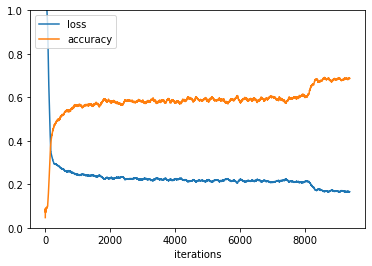

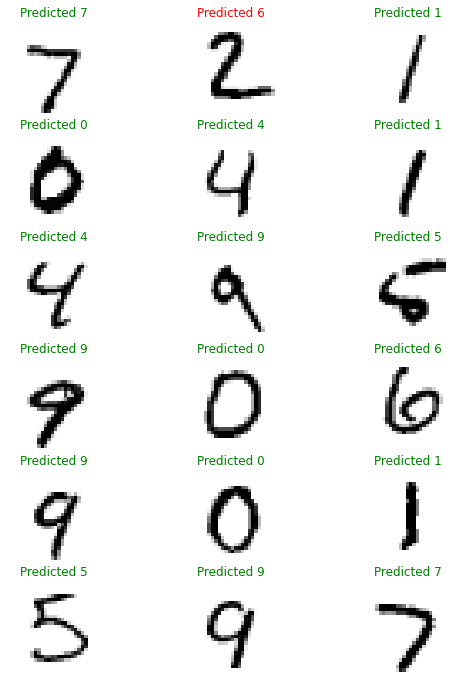

In [0]:
(
    (mnist_train_images, mnist_train_labels),
    (mnist_test_images, mnist_test_labels),
) = tf.keras.datasets.mnist.load_data()
mnist_train_images = mnist_train_images / 255.0
mnist_test_images = mnist_test_images / 255.0

mnist_total_classes = 10
mnist_train_vec_labels = tf.keras.utils.to_categorical(
    mnist_train_labels, mnist_total_classes)
mnist_test_vec_labels = tf.keras.utils.to_categorical(mnist_test_labels, mnist_total_classes)

mnistModel = ScratchNet(
    [
        FlattenLayer(input_shape=(28, 28)),
        DenseLayer(128, activation=Sigmoid()),
        DenseLayer(10, activation=Sigmoid()),
    ]
)

# Zeigt die Struktur und Initialisierung des Netzes
# model.inspect()

mnistModel.compile(learning_rate=5.0, loss=SquaredError())
start = time.time()
mnist_losses, mnist_accuracies = mnistModel.fit(
    mnist_train_images, mnist_train_vec_labels, epochs=10, batch_size=64
)
end = time.time()
print("Trainingsdauer: {:.1f}s".format(end - start))

mnist_val_loss, mnist_val_acc = mnistModel.evaluate(
    validation_images=mnist_test_images, validation_labels=mnist_test_vec_labels
)
print(f"Validation loss: {mnist_val_loss}")
print(f"Validation accuracy: {mnist_val_acc}")

plot_loss_and_accuracy(mnist_losses, mnist_accuracies, xlabel="iterations")

helpers.plot_predictions(
    mnistModel, mnist_test_images[:20], labels=mnist_test_vec_labels[:20])